# Классификация облаков

[Dataset](https://www.kaggle.com/competitions/understanding_cloud_organization/data)

Сделаем модель для многоклассовой классификации с пересекающимися классами (на фотографии могут быть облака любых классов в любых сочетаниях). В задаче определены 4 класса: Fish, Flower, Gravel, Sugar. Модель будет выдавать ответ: есть ли один из перечисленных классов на изображении — у модели будет 4 выхода, чтобы показывать наличие каждого класса.

Маркированные данные в наборе данных предоставлены только для набора изображений Train_images. Поэтому разделим Train_images на train, validation, test datasets. Метки классов содержатся в файле train.csv .

In [1]:
#!pip install pillow
#!pip install tensorboard
import os
import random
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score
import torchmetrics.functional
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed) # Фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # Фиксируем заполнения хешей
    np.random.seed(seed) # Фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # Фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # Фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # Выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # Фиксируем алгоритм вычисления сверток

def drawResultsOfTrain(metric_list):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(metric_list, lw=3)
    ax.set_title("Training metric by validation dataset", size=15)
    ax.set_xlabel('Iteration', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show() 

In [3]:
BATCH_SIZE = 64

seed_everything(42)

NUM_WORKERS = os.cpu_count()
torch.set_num_threads(NUM_WORKERS)
print('Threads:', torch.get_num_threads())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE_DATA = 'cpu' # Dataset не поместился в доступной памяти GPU, иначе можно было быиспользовать значение =DEVICE
torch.set_default_device(DEVICE)
print(DEVICE)

torch.set_float32_matmul_precision('medium')


Threads: 26
cuda


## Предобработка данных

"Your prediction masks should be scaled down to 350 x 525 px." — пересохраним набор данных в разрешении 525х350 в подкаталог Train_images_scaled.

Нейронная сеть будет принимать на вход изображения данного фиксированного размера.

In [5]:
def rescale_images(path_input, path_output):
    for filename in tqdm(os.listdir(path_input)):
        if filename.endswith('.jpg'):
            # Open the image
            img_path = os.path.join(path_input, filename)
            img = Image.open(img_path)
            
            # Resize the image maintaining aspect ratio
            resized_img = ImageOps.contain(img, (525, 350))
            
            # If resized image is smaller than desired size, add black borders
            if resized_img.size[0] < 525 or resized_img.size[1] < 350:
                new_img = Image.new('RGB', (525, 350), 'black')
                x_offset = int((525 - resized_img.width)/2)
                y_offset = int((350 - resized_img.height)/2)
                new_img.paste(resized_img, (x_offset, y_offset))
                resized_img = new_img
                
            # Save the resized and potentially padded image to the output directory
            save_path = os.path.join(path_output, filename)
            resized_img.save(save_path, 'JPEG', quality=95)

path_input = 'C:\Temp\Dataset Clouds\Train_images'
path_output = './Train_images_scaled'
rescale_images(path_input, path_output)

100%|██████████| 5546/5546 [05:32<00:00, 16.70it/s]


Преобразуем файл с метками классов train.csv в более удобный для работы вид —  с колонками:
- ImageName — имя файла
- Fish — бинарный признак наличия класса
- Flower — бинарный признак наличия класса
- Gravel — бинарный признак наличия класса
- Sugar — бинарный признак наличия класса

In [33]:
train_csv = pd.read_csv('train.csv')
label_csv = pd.DataFrame(columns=['ImageName', 'Fish', 'Flower', 'Gravel', 'Sugar'])

def getInitialyzedClasses():
    return {'Fish': 0, 'Flower': 0, 'Gravel': 0, 'Sugar': 0}

imageNameCurrent = ''
classes = getInitialyzedClasses()
for record in tqdm(train_csv.itertuples()):
    if not pd.isnull(record.EncodedPixels):
        imageName, className = record.Image_Label.split('_')

        if imageNameCurrent == '':
            imageNameCurrent = imageName

        if imageName != imageNameCurrent:
            new_row = {'ImageName': imageNameCurrent,
                        'Fish': classes['Fish'],
                        'Flower': classes['Flower'],
                        'Gravel': classes['Gravel'],
                        'Sugar': classes['Sugar']}
        
            label_csv = pd.concat([label_csv, pd.DataFrame([new_row])], ignore_index=True)

            classes = getInitialyzedClasses()
            imageNameCurrent = imageName

        classes[className] = 1

label_csv.to_csv('labels.csv', index=False)
label_csv.head()

22184it [00:01, 12738.87it/s]


,ImageName,Fish,Flower,Gravel,Sugar
0,0011165.jpg,1,1,0,0
1,002be4f.jpg,1,1,0,1
2,0031ae9.jpg,1,1,0,1
3,0035239.jpg,0,1,1,0
4,003994e.jpg,1,0,1,1


## Загрузим данные

Dataset помещается в ОЗУ 64 Гб, поэтому загрузим сразу все данные в ОЗУ для ускорения работы.

In [4]:
class CloudsDataset(Dataset):
    def __init__(self, data_path, label_csv_path):
        self._data = []
        voc_labels = {}
        transform = transforms.Compose([transforms.ToTensor()])

        label_csv = pd.read_csv(label_csv_path)
        for record in label_csv.itertuples():
            voc_labels[record.ImageName] = (record.Fish, record.Flower, record.Gravel, record.Sugar)

        for image_name, labels in voc_labels.items():
            img = Image.open(os.path.join(data_path, image_name))
            img = img.convert('RGB')
            self._data.append((transform(img).to(DEVICE_DATA), 
                               torch.tensor(labels, dtype=torch.float32).to(DEVICE_DATA)))

    def __getitem__(self, index):
        return self._data[index]
    
    def __len__(self):
        return len(self._data)

In [5]:
class CloudsDataModule(pl.LightningDataModule):
    def __init__(self, data_path=r'./Train_images_scaled', label_csv_path=r'labels.csv'):
        super().__init__()
        self.data_path = data_path
        self.labels_path = label_csv_path

    def prepare_data(self):
        self.dataset = CloudsDataset(self.data_path, self.labels_path)
        print('Загружены данные, объектов: ', len(self.dataset))

    def setup(self, stage=None):
        self.train, self.val, self.test = random_split(self.dataset, 
                                                       [0.7, 0.15, 0.15],
                                                       generator = torch.Generator(device=DEVICE).manual_seed(0)
                                                       )
        print('Загруженные данные разделены на наборы данных train:', len(self.train), 
              '; validation:', len(self.val),
              ';test:', len(self.test))
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=BATCH_SIZE) # нельзя задать num_workers, вызывает ошибку
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=BATCH_SIZE)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=BATCH_SIZE)

## Создаём сеть

In [6]:
class CNNClassifier(pl.LightningModule):
    def __init__(self, image_shape=(3, 525, 350)):
        super().__init__()
        self.training_step_outputs = []

        self.train_acc = MultilabelAccuracy(4) # MultilabelF1Score(num_labels=4, average='macro')
        self.valid_acc = MultilabelAccuracy(4) # MultilabelF1Score(num_labels=4, average='macro')
        self.test_acc = MultilabelF1Score(num_labels=4, average='macro')

        self.valid_metric = []

        all_layers = [nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1), # в монохромное
                      nn.ReLU(),
                      nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1), # CNN 1
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=5, stride=5), # to size: (105, 70)
                      nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1), # CNN 2
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=5, stride=5), # to size: (21, 14)
                      nn.Conv2d(in_channels=32, out_channels=8, kernel_size=3, padding=1), # CNN 3
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=7, stride=7), # to size: (3, 2)
                      nn.Flatten(), 
                      nn.Linear(48, 16), # FNN
                      nn.Tanh(),
                      nn.Dropout(0.1),
                      nn.Linear(16, 4),
                      nn.Sigmoid()
                      ]

        self.model = nn.Sequential(*all_layers)
        self.loss_fn = nn.BCEWithLogitsLoss() ##nn.MultiLabelSoftMarginLoss()
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.model(x)
        return y
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_preds = self(x)
        loss = self.loss_fn(y_preds, y)
        self.training_step_outputs.append(loss)
        self.train_acc.update(y_preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        self.log("training_epoch_average", epoch_average)
        self.training_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_preds = self(x)
        loss = self.loss_fn(y_preds, y)
        self.valid_acc.update(y_preds, y)
        self.log('valid_loss', loss, prog_bar=True)
        current_valid_acc = self.valid_acc.compute()
        self.log('valid_acc', current_valid_acc, prog_bar=True)
        self.valid_metric.append(current_valid_acc.to('cpu').item())
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_preds = self(x)
        loss = self.loss_fn(y_preds, y)
        self.test_acc.update(y_preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc.compute(), prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=1e-5) # with L2 regularization
        return optimizer

## Тренируем модель

In [7]:
epochs = 40

model = CNNClassifier().to(DEVICE)

early_stopping = EarlyStopping('valid_loss', min_delta=0.05, patience=5)

if DEVICE == 'cuda':
    trainer = pl.Trainer(max_epochs=epochs, callbacks=[early_stopping], gradient_clip_val=0.5,
                         accelerator="gpu", devices=1, strategy="auto")
else:
    trainer = pl.Trainer(max_epochs=epochs, callbacks=[early_stopping], gradient_clip_val=0.5)

clouds_dm = CloudsDataModule('Train_images_scaled', 'labels.csv')
trainer.fit(model=model, datamodule=clouds_dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Загружены данные, объектов:  5545
Загруженные данные разделены на наборы данных train: 3882 ; validation: 832 ;test: 831



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | train_acc | MultilabelAccuracy | 0      | train
1 | valid_acc | MultilabelAccuracy | 0      | train
2 | test_acc  | MultilabelF1Score  | 0      | train
3 | model     | Sequential         | 41.3 K | train
4 | loss_fn   | BCEWithLogitsLoss  | 0      | train
---------------------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

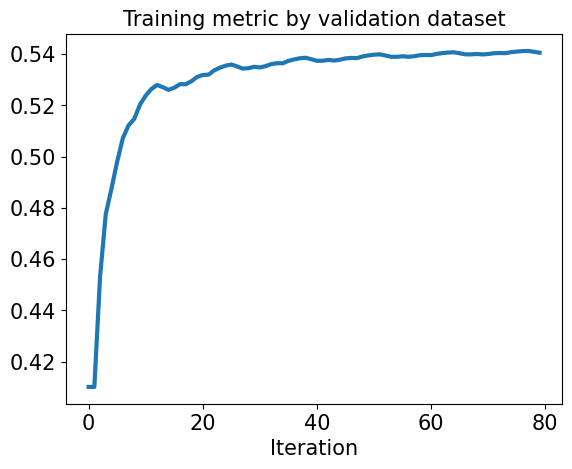

In [8]:
drawResultsOfTrain(model.valid_metric)

In [9]:
trainer.validate(model=model, datamodule=clouds_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Загружены данные, объектов:  5545
Загруженные данные разделены на наборы данных train: 3882 ; validation: 832 ;test: 831


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         valid_acc         │    0.5409902930259705     │
│        valid_loss         │     0.673613429069519     │
└───────────────────────────┴───────────────────────────┘

[{'valid_loss': 0.673613429069519, 'valid_acc': 0.5409902930259705}]

В tensorboard:
- version_0 — без gradient clipping
- version_1 — с gradient clipping
- version_2 — с gradient clipping, тестовая метрика Dice (F1)

In [145]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6008 (pid 16016), started 2 days, 0:38:29 ago. (Use '!kill 16016' to kill it.)

## Финальный тест:

In [10]:
print('Контроль технической корректности работы модели')
obj = clouds_dm.test_dataloader().dataset[0][0].to(DEVICE)
obj = obj.unsqueeze(0)
print('expected labels:\t', clouds_dm.test_dataloader().dataset[0][1])
model.eval()
model.to(DEVICE)
with torch.no_grad():
    print('predicted labels:\t', model(obj))

Контроль технической корректности работы модели
expected labels:	 tensor([1., 1., 0., 1.])
predicted labels:	 tensor([[0.0077, 0.0008, 0.0961, 0.7920]], device='cuda:0')


In [11]:
trainer.test(model=model, datamodule=clouds_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Загружены данные, объектов:  5545
Загруженные данные разделены на наборы данных train: 3882 ; validation: 832 ;test: 831


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2054155468940735     │
│         test_loss         │    0.6752669811248779     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6752669811248779, 'test_acc': 0.2054155468940735}]